## Business Intelligence Exam - The Danish Housing Market

### Data Cleaning

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [26]:
ejer_file_path = '/Users/martinthuren/Desktop/ejerlejlighed.xlsx'
parcelrække_file_path = '/Users/martinthuren/Desktop/parcelogrækkehuse.xlsx'

In [27]:
ejer = pd.read_excel(ejer_file_path, index_col=0)  
parcelogrække = pd.read_excel(parcelrække_file_path, index_col=0) 

In [28]:
# Replace ".." with NaN
ejer.replace("..", np.nan, inplace=True)
parcelogrække.replace("..", np.nan, inplace=True)

In [29]:
# Replace 0 with NaN
ejer.replace(0, np.nan, inplace=True)
parcelogrække.replace(0, np.nan, inplace=True)

In [30]:
# Convert data types to numeric
ejer = ejer.apply(pd.to_numeric, errors='coerce')
parcelogrække = parcelogrække.apply(pd.to_numeric, errors='coerce')

In [31]:
# Drop rows with all NaN values
ejer.dropna(axis=0, how='all', inplace=True)
parcelogrække.dropna(axis=0, how='all', inplace=True)

### Unsupervised machine learning: clustering

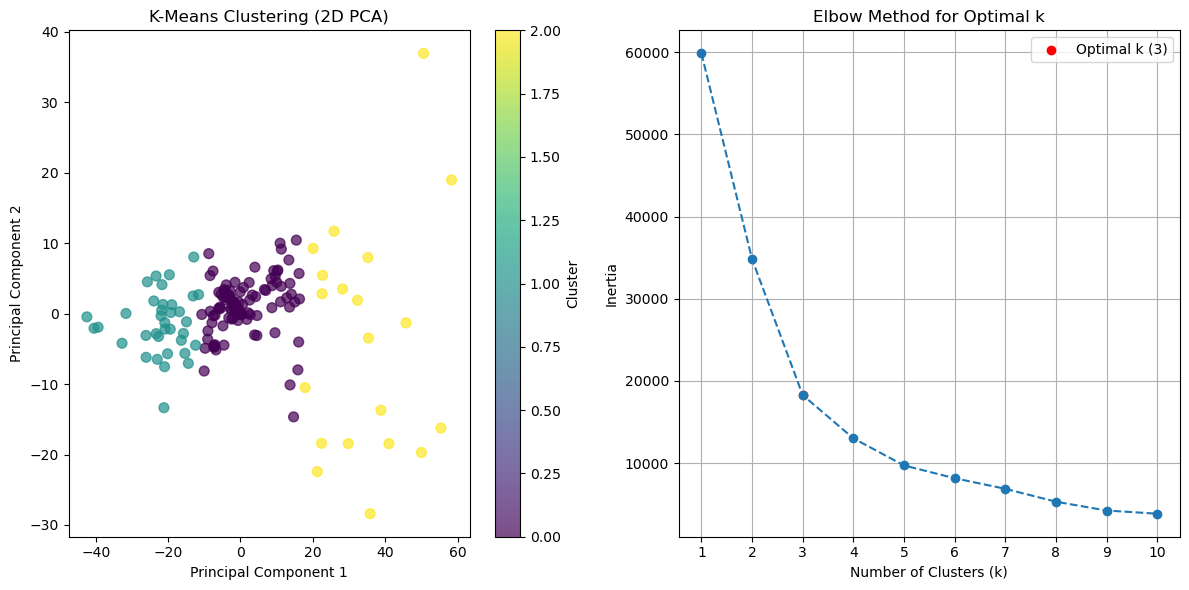

The most precise number of clusters based on the elbow method: 3
Silhouette Score: 0.841447831968249


In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from kneed import KneeLocator

# Read the data from Excel file
excel_file = '/Users/martinthuren/Desktop/ejerlejlighed.xlsx'
df = pd.read_excel(excel_file)

# Set the first row as the column names
df.columns = df.iloc[0]

# Drop the first row (as it's now redundant)
df = df.drop(0)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Drop the 'Unnamed: 0' column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Replace '..' with NaN
df.replace('..', pd.NA, inplace=True)

# Drop columns with all NaN values
df.dropna(axis=1, how='all', inplace=True)

# Convert columns to numeric (excluding the first column)
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric)

# Impute missing values with column means
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df.iloc[:, 1:])

# Apply feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Initialize a list to store inertia values for different k
inertia_values = []

# Try different values of k and calculate inertia
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)

# Find the optimal number of clusters using the "knee" in the elbow method curve
kneedle = KneeLocator(range(1, 11), inertia_values, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

# Re-fit the KMeans model with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_pca)

# Calculate the silhouette score
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)

# Plot the original clustering
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.7)
plt.title('K-Means Clustering (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

# Plot the elbow method curve
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), inertia_values, marker='o', linestyle='--')
plt.scatter(optimal_k, inertia_values[optimal_k-1], color='red', label=f'Optimal k ({optimal_k})')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"The most precise number of clusters based on the elbow method: {optimal_k}")
print(f"Silhouette Score: {silhouette_avg}")


## Prediction of housing price pr square meter in Copenhagen

23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing


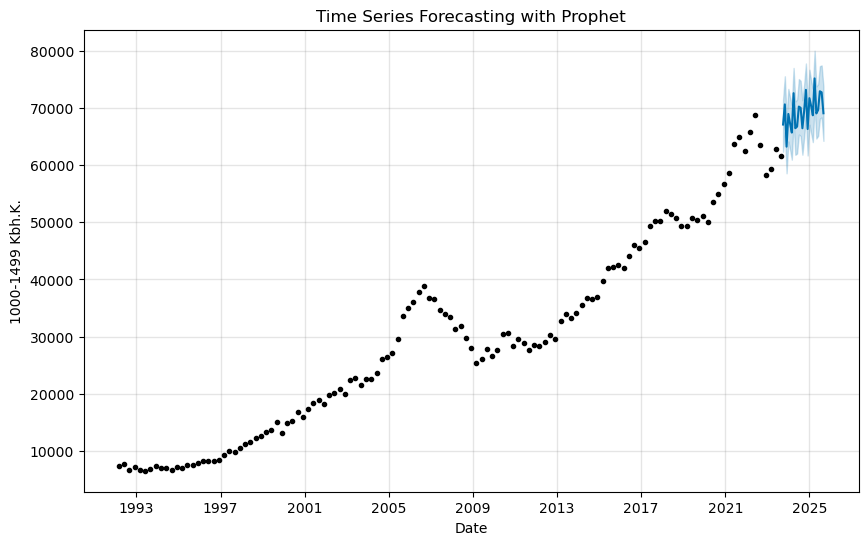

In [33]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 1: Read the dataset from an Excel file
excel_file = '/Users/martinthuren/Desktop/ejerlejlighed.xlsx'
df = pd.read_excel(excel_file, index_col=0)

# Step 2: Prepare the data for time series forecasting
# Transpose the DataFrame to have time series as rows and features as columns
df = df.transpose()

# Convert the index to datetime type using a custom parser
def custom_date_parser(date_string):
    year = date_string[:4]
    quarter = date_string[-2:]
    if quarter == 'K1':
        month = 3
    elif quarter == 'K2':
        month = 6
    elif quarter == 'K3':
        month = 9
    else:
        month = 12
    return pd.to_datetime(f'{year}-{month}-01')

df.index = df.index.map(custom_date_parser)

# Step 3: Train a forecasting model with Prophet
# Rename columns as required by Prophet
df.reset_index(inplace=True)
df.rename(columns={'index': 'ds', '1000-1499 Kbh.K.': 'y'}, inplace=True)

# Initialize Prophet model
model = Prophet()

# Fit the model to the data
model.fit(df)

# Step 4: Forecast future values
# Generate future time indices for forecasting
future_indices = pd.date_range(start=df['ds'].iloc[-1], periods=24, freq='M')  # Forecasting for 10 months

# Create a DataFrame with future indices
future_df = pd.DataFrame({'ds': future_indices})

# Make predictions for future values
forecast = model.predict(future_df)

# Step 5: Visualize the forecasted values
plt.figure(figsize=(10, 6))
model.plot(forecast, xlabel='Date', ylabel='1000-1499 Kbh.K.', ax=plt.gca())
plt.title('Time Series Forecasting with Prophet')
plt.grid(True)
plt.show()

## Comparison betweeen ejerlejlighed and parcelogrække through time


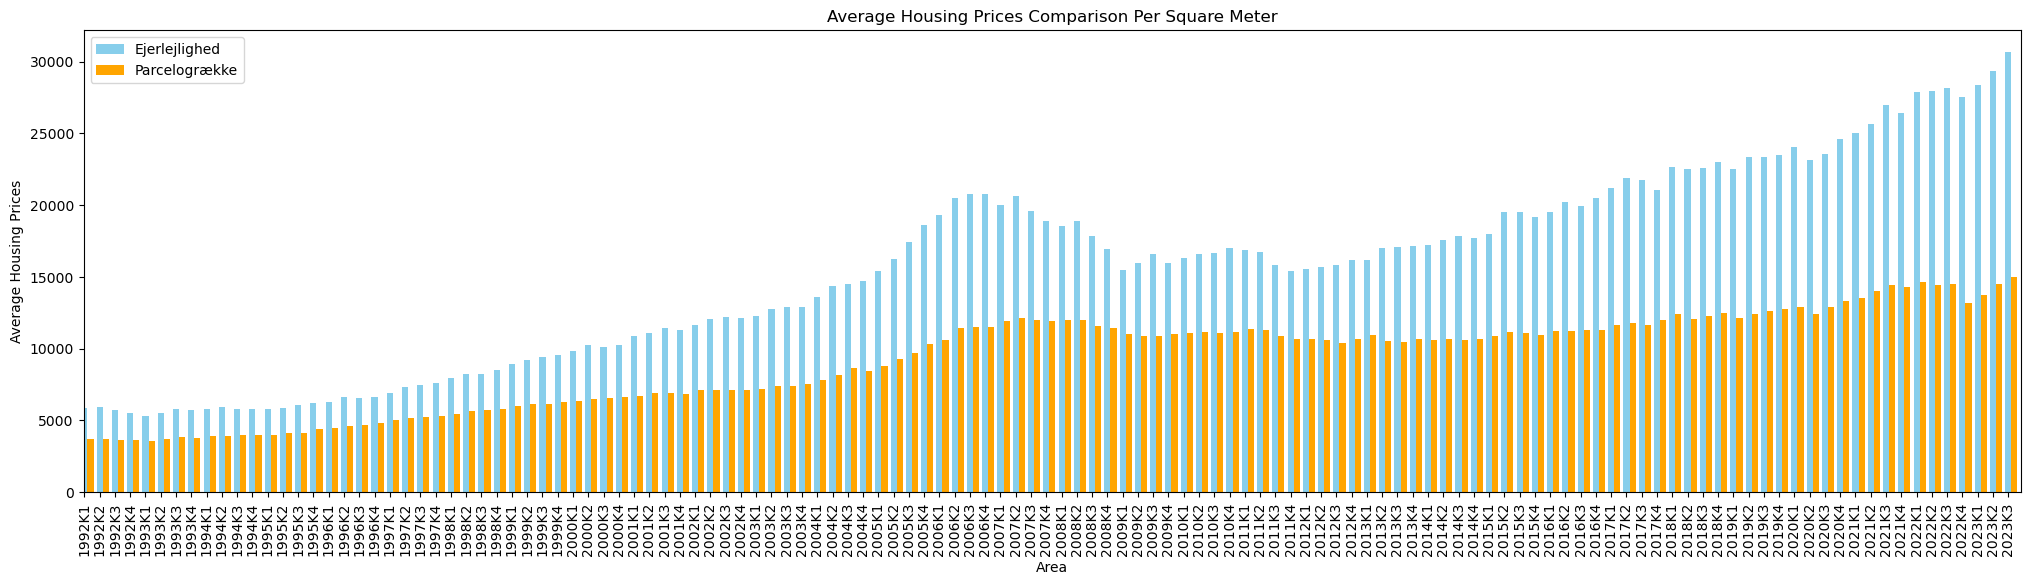

In [34]:
# Read the datasets for housing prices
ejer = pd.read_excel(ejer_file_path, index_col=0)
parcelogrække = pd.read_excel(parcelrække_file_path, index_col=0)

# Calculate the average housing prices across all areas
average_ejer_prices = ejer.mean(axis=0)
average_parcelogrække_prices = parcelogrække.mean(axis=0)

# Set the figure size to make the plot wider
plt.figure(figsize=(25, 6))  # Adjust the width (25) and height (6) as needed

# Create the bar chart
average_ejer_prices.plot(kind='bar', color='skyblue', position=0.5, width=0.4, label='Ejerlejlighed')
average_parcelogrække_prices.plot(kind='bar', color='orange', position=-0.5, width=0.4, label='Parcelogrække')

plt.title('Average Housing Prices Comparison Per Square Meter')
plt.xlabel('Area')
plt.ylabel('Average Housing Prices')
plt.legend()
plt.show()
